# Modèles PyTorch - Classification et Régression

Ce notebook implémente deux modèles simples avec PyTorch:
1. **Classification**: Prédire si un étudiant va compléter le cours (Completed: 0 ou 1)
2. **Régression**: Prédire Quiz_Score_Avg, Project_Grade, Satisfaction_Rating, Time_Spent_Hours

In [79]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Vérifier si GPU disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device utilisé: {device}")

Device utilisé: cpu


## 1. Chargement des données

In [81]:
# Classification
X_class = pd.read_csv('../data/processed/X_classification.csv')
y_class = pd.read_csv('../data/processed/y_classification.csv')

# Régression
X_reg = pd.read_csv('../data/processed/X_regression.csv')
y_reg = pd.read_csv('../data/processed/y_regression.csv')

print("CLASSIFICATION:")
print(f"X_class: {X_class.shape}")
print(f"y_class: {y_class.shape}")

print("\nREGRESSION:")
print(f"X_reg: {X_reg.shape}")
print(f"y_reg: {y_reg.shape}")

CLASSIFICATION:
X_class: (56172, 42)
y_class: (56172, 1)

REGRESSION:
X_reg: (56172, 37)
y_reg: (56172, 4)


---
# PARTIE 1: MODELE DE CLASSIFICATION
---

**Objectif**: Prédire si un étudiant va compléter le cours (0 ou 1)

In [ ]:
# Préparation des données - Classification
X_class_np = X_class.values
y_class_np = y_class.values.ravel()

# 1. Train (70%) / Test (30%)
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class_np, y_class_np, test_size=0.30, random_state=42)

# 2. test (15%) / val (15%) 
X_test_class, X_val_class, y_test_class, y_val_class = train_test_split(X_train_class, y_train_class, test_size=0.5, random_state=42)

X_train_class_tensor = torch.FloatTensor(X_train_class).to(device)
X_val_class_tensor = torch.FloatTensor(X_val_class).to(device)
X_test_class_tensor = torch.FloatTensor(X_test_class).to(device)
y_train_class_tensor = torch.FloatTensor(y_train_class).to(device)
y_val_class_tensor = torch.FloatTensor(y_val_class).to(device)
y_test_class_tensor = torch.FloatTensor(y_test_class).to(device)

print(f"Données Classification: Train={X_train_class_tensor.shape[0]}, Val={X_val_class_tensor.shape[0]}, Test={X_test_class_tensor.shape[0]}")

Données Classification: Train=39320, Val=19660, Test=19660


In [85]:
# Modèle de Classification
class CourseCompletionClassifier(nn.Module):
    def __init__(self, input_dim):
        super(CourseCompletionClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256), 
            nn.BatchNorm1d(256), 
            nn.ReLU(), 
            nn.Dropout(0.3),

            nn.Linear(256, 128),        
            nn.BatchNorm1d(128),  
            nn.ReLU(), 
            nn.Dropout(0.3),

            nn.Linear(128, 64),         
            nn.BatchNorm1d(64),  
            nn.ReLU(), 
            nn.Dropout(0.2),

            nn.Linear(64, 32),         
            nn.BatchNorm1d(32),  
            nn.ReLU(), 
            nn.Dropout(0.1),

            nn.Linear(32, 1),          
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

model_class = CourseCompletionClassifier(X_train_class_tensor.shape[1]).to(device)

In [88]:
# Entraînement Classification avec Early Stopping
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_class.parameters(), lr=0.01)

best_val_loss = float('inf')
patience = 40
counter = 0
train_history, val_history = [], []

for epoch in range(400):
    model_class.train()
    optimizer.zero_grad()
    output = model_class(X_train_class_tensor)
    loss = criterion(output.squeeze(), y_train_class_tensor)
    loss.backward()
    optimizer.step()
    
    # Validation step
    model_class.eval()
    with torch.no_grad():
        val_out = model_class(X_val_class_tensor)
        val_loss = criterion(val_out.squeeze(), y_val_class_tensor)
    
    train_history.append(loss.item())
    val_history.append(val_loss.item())
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_class.state_dict(), 'best_clf_model.pth')
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
            
    if (epoch+1) % 20 == 0: 
        print(f"Epoch {epoch+1:03d} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

Epoch 020 | Train Loss: 0.5480 | Val Loss: 0.4505
Epoch 040 | Train Loss: 0.5349 | Val Loss: 0.4448
Epoch 060 | Train Loss: 0.5299 | Val Loss: 0.4288
Epoch 080 | Train Loss: 0.5227 | Val Loss: 0.4152
Epoch 100 | Train Loss: 0.5204 | Val Loss: 0.4006
Epoch 120 | Train Loss: 0.5151 | Val Loss: 0.4010
Epoch 140 | Train Loss: 0.5115 | Val Loss: 0.3834
Epoch 160 | Train Loss: 0.5060 | Val Loss: 0.3782
Epoch 180 | Train Loss: 0.5029 | Val Loss: 0.3704
Epoch 200 | Train Loss: 0.4974 | Val Loss: 0.3709
Epoch 220 | Train Loss: 0.4965 | Val Loss: 0.3745
Epoch 240 | Train Loss: 0.4945 | Val Loss: 0.3592
Epoch 260 | Train Loss: 0.4937 | Val Loss: 0.3625
Epoch 280 | Train Loss: 0.4906 | Val Loss: 0.3544
Epoch 300 | Train Loss: 0.4879 | Val Loss: 0.3529
Epoch 320 | Train Loss: 0.4859 | Val Loss: 0.3516
Epoch 340 | Train Loss: 0.4843 | Val Loss: 0.3357
Epoch 360 | Train Loss: 0.4826 | Val Loss: 0.3434
Epoch 380 | Train Loss: 0.4800 | Val Loss: 0.3423
Epoch 400 | Train Loss: 0.4748 | Val Loss: 0.3388


Accuracy sur le test set: 0.8870 (88.70%)


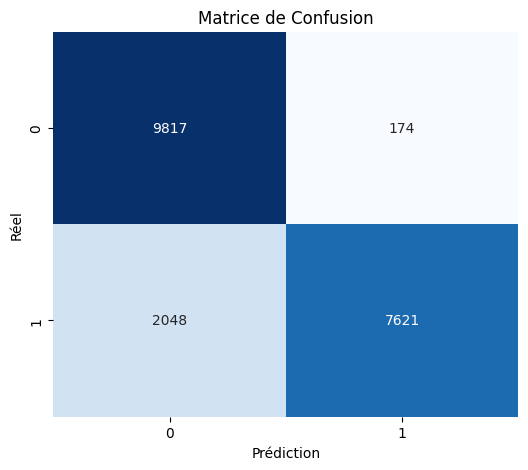


Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.98      0.90      9991
         1.0       0.98      0.79      0.87      9669

    accuracy                           0.89     19660
   macro avg       0.90      0.89      0.89     19660
weighted avg       0.90      0.89      0.89     19660



In [89]:
# EVALUATION - CLASSIFICATION
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

model_class.eval()
with torch.no_grad():
    y_pred_test = model_class(X_test_class_tensor)
    y_pred_classes = (y_pred_test.squeeze() > 0.5).float()

y_pred_np = y_pred_classes.cpu().numpy()
y_test_np = y_test_class_tensor.cpu().numpy()

# Accuracy
accuracy = accuracy_score(y_test_np, y_pred_np)
print(f"Accuracy sur le test set: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Confusion Matrix
cm = confusion_matrix(y_test_np, y_pred_np)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matrice de Confusion')
plt.xlabel('Prédiction')
plt.ylabel('Réel')
plt.show()

# Detailed Report
print("\nClassification Report:")
print(classification_report(y_test_np, y_pred_np))

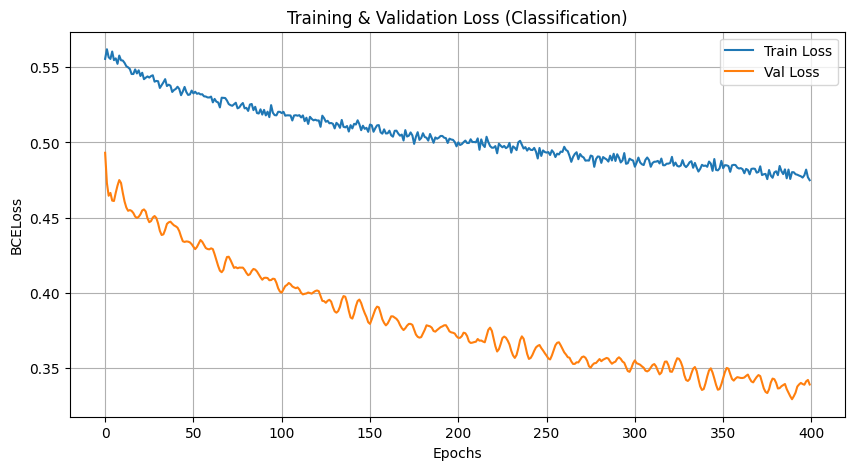

In [90]:
plt.figure(figsize=(10, 5))
plt.plot(train_history, label='Train Loss')
plt.plot(val_history, label='Val Loss')
plt.title('Training & Validation Loss (Classification)')
plt.xlabel('Epochs')
plt.ylabel('BCELoss')
plt.legend()
plt.grid(True)
plt.show()

---
# PARTIE 2: MODELE DE REGRESSION
---

**Objectif**: Prédire 4 variables continues:
- Quiz_Score_Avg
- Project_Grade  
- Satisfaction_Rating
- Time_Spent_Hours

In [91]:
# Préparation des données - Régression
X_reg_np = X_reg.values
y_reg_np = y_reg.values

# 1. Train (70%) / Test (30%)
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class_np, y_class_np, test_size=0.30, random_state=42)

# 2. test (15%) / val (15%) 
X_test_class, X_val_class, y_test_class, y_val_class = train_test_split(X_train_class, y_train_class, test_size=0.5, random_state=42)

# To Tensor
X_train_reg_t = torch.FloatTensor(X_train_reg).to(device)
X_val_reg_t = torch.FloatTensor(X_val_reg).to(device)
X_test_reg_t = torch.FloatTensor(X_test_reg).to(device)
y_train_reg_t = torch.FloatTensor(y_train_reg).to(device)
y_val_reg_t = torch.FloatTensor(y_val_reg).to(device)
y_test_reg_t = torch.FloatTensor(y_test_reg).to(device)

print(f"Données Classification: Train={X_train_class_tensor.shape[0]}, Val={X_val_class_tensor.shape[0]}, Test={X_test_class_tensor.shape[0]}")

Données Classification: Train=39320, Val=19660, Test=19660


In [62]:
# Modèle de Régression Amélioré
class StudentPerformanceRegressor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(StudentPerformanceRegressor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256), 
            nn.BatchNorm1d(256), 
            nn.ReLU(), 
            nn.Dropout(0.2),

            nn.Linear(256, 128),       
            nn.BatchNorm1d(128), 
            nn.ReLU(), 
            nn.Dropout(0.2),

            nn.Linear(128, 64),        
            nn.BatchNorm1d(64),  
            nn.ReLU(), 
            nn.Dropout(0.1),

            nn.Linear(64, 32),         
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )

    def forward(self, x):
        return self.net(x)

model_reg = StudentPerformanceRegressor(X_train_reg_t.shape[1], y_train_reg_t.shape[1]).to(device)

In [ ]:
# Entraînement Régression avec Early Stopping
criterion_reg = nn.MSELoss()
optimizer_reg = torch.optim.Adam(model_reg.parameters(), lr=0.001)

best_reg_loss = float('inf')
patience_reg = 20
counter_reg = 0
r_train_hist, r_val_hist = [], []

print("Training Regression Model...")
for epoch in range(250):
    model_reg.train()
    optimizer_reg.zero_grad()
    pred = model_reg(X_train_reg_t)
    loss = criterion_reg(pred, y_train_reg_t)
    loss.backward()
    optimizer_reg.step()
    
    model_reg.eval()
    with torch.no_grad():
        val_pred = model_reg(X_val_reg_t)
        val_loss = criterion_reg(val_pred, y_val_reg_t)
    
    r_train_hist.append(loss.item())
    r_val_hist.append(val_loss.item())

    if val_loss < best_reg_loss:
        best_reg_loss = val_loss
        torch.save(model_reg.state_dict(), 'best_reg_model.pth')
        counter_reg = 0
    else:
        counter_reg += 1
        if counter_reg >= patience_reg:
            print(f"Early stopping at epoch {epoch+1}")
            break
            
    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1:03d} | Train MSE: {loss.item():.4f} | Val MSE: {val_loss.item():.4f}")

Training Regression Model...
Epoch 020 | Train MSE: 2548.5315 | Val MSE: 2545.5276
Epoch 040 | Train MSE: 2451.8689 | Val MSE: 2404.6025
Epoch 060 | Train MSE: 2275.9170 | Val MSE: 2198.3958
Epoch 080 | Train MSE: 2015.6252 | Val MSE: 1954.9811
Epoch 100 | Train MSE: 1677.3929 | Val MSE: 1661.9098
Epoch 120 | Train MSE: 1288.9507 | Val MSE: 1304.9446
Epoch 140 | Train MSE: 884.5185 | Val MSE: 876.9194
Epoch 160 | Train MSE: 530.1884 | Val MSE: 515.3863
Epoch 180 | Train MSE: 277.8556 | Val MSE: 248.2440
Epoch 200 | Train MSE: 151.4964 | Val MSE: 169.6251
Epoch 220 | Train MSE: 104.2435 | Val MSE: 116.4034
Epoch 240 | Train MSE: 88.8259 | Val MSE: 104.7421
Best Regression Model Loaded.


In [70]:
# Évaluation Régression
model_reg.eval()
with torch.no_grad():
    y_pred_scaled = model_reg(X_test_reg_t).cpu().numpy()
    y_test_scaled = y_test_reg_t.cpu().numpy()

# Inverse transform
y_pred_final = scaler_y.inverse_transform(y_pred_scaled)
y_test_final = scaler_y.inverse_transform(y_test_scaled)

target_names = ["Quiz_Score_Avg", "Project_Grade", "Satisfaction_Rating", "Time_Spent_Hours"]
print("\n--- Résultats Régression ---")
for i, col in enumerate(target_names):
    rmse = np.sqrt(mean_squared_error(y_test_final[:, i], y_pred_final[:, i]))
    r2 = r2_score(y_test_final[:, i], y_pred_final[:, i])
    print(f"{col:15} | RMSE: {rmse:.3f} | R2: {r2:.3f}")



--- Résultats Régression ---
Quiz_Score_Avg  | RMSE: 190.368 | R2: -0.454
Project_Grade   | RMSE: 199.499 | R2: 0.283
Satisfaction_Rating | RMSE: 0.604 | R2: -0.491
Time_Spent_Hours | RMSE: 14.230 | R2: -0.001


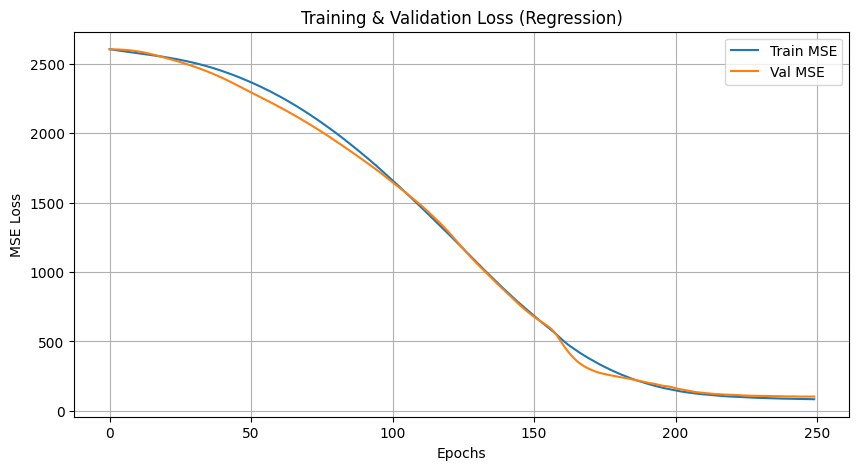

In [71]:
plt.figure(figsize=(10, 5))
plt.plot(r_train_hist, label='Train MSE')
plt.plot(r_val_hist, label='Val MSE')
plt.title('Training & Validation Loss (Regression)')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

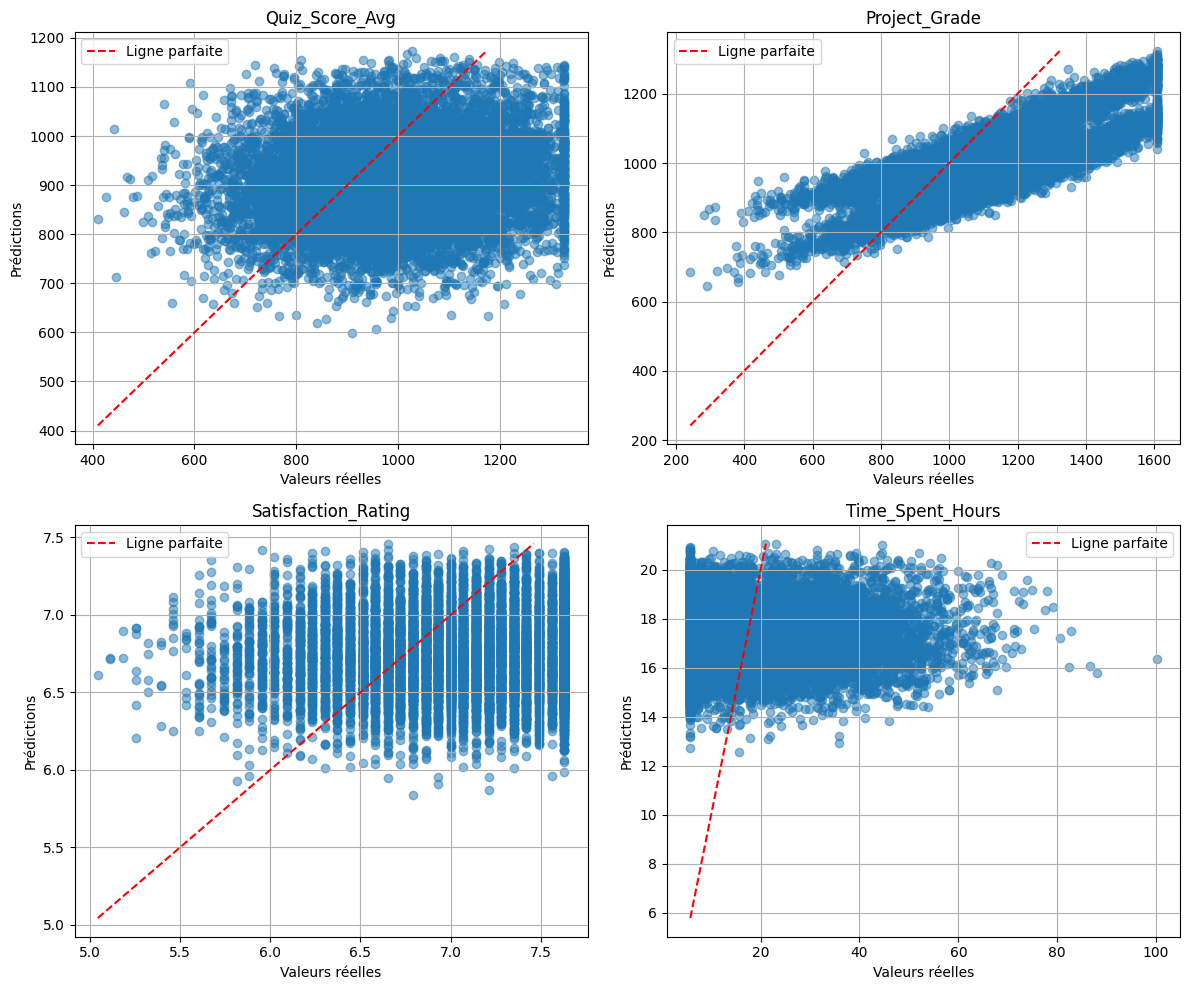

In [73]:
# VISUALISATION - PREDICTIONS vs VALEURS REELLES

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
target_names = ["Quiz_Score_Avg", "Project_Grade", "Satisfaction_Rating", "Time_Spent_Hours"]
for i, (ax, name) in enumerate(zip(axes, target_names)):
    ax.scatter(y_test_final[:, i], y_pred_final[:, i], alpha=0.5)
    ax.plot([y_test_final[:, i].min(), y_pred_final[:, i].max()],
            [y_test_final[:, i].min(), y_pred_final[:, i].max()],
            'r--', label='Ligne parfaite')
    ax.set_xlabel('Valeurs réelles')
    ax.set_ylabel('Prédictions')
    ax.set_title(f'{name}')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

## Résumé

### Architecture des modèles

Les deux modèles utilisent une architecture simple:
- **Couche 1**: Entrée → 64 neurones (ReLU)
- **Couche 2**: 64 → 32 neurones (ReLU)
- **Couche de sortie**: 
  - Classification: 32 → 1 (Sigmoid)
  - Régression: 32 → 4 (pas d'activation)

### Hyperparamètres
- Optimiseur: Adam
- Learning rate: 0.001
- Epochs: 100
- Fonction de perte:
  - Classification: Binary Cross Entropy (BCELoss)
  - Régression: Mean Squared Error (MSELoss)

In [ ]:
# ANALYSE DES POIDS (Feature Importance)

def analyze_weights(model, feature_names, task_name):
    print(f'\n--- Analyse des poids : {task_name} ---')
    # Poids de la première couche (Linear)
    # Dans un nn.Sequential, le premier module est à l'index 0
    weights = model[0].weight.data.cpu().numpy()
    
    # Importance moyenne absolue
    feature_importance = np.mean(np.abs(weights), axis=0)
    
    # DataFrame
    df_imp = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values(by='Importance', ascending=False)
    
    print('Top 10 Variables Influentes :')
    print(df_imp.head(10))
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(df_imp['Feature'].head(10)[::-1], df_imp['Importance'].head(10)[::-1])
    plt.title(f'Feature Importance - {task_name}')
    plt.xlabel('Mean Absolute Weight')
    plt.show()
    
    return df_imp

# Récupérer les noms des features (X_classification a les colonnes)
features_class = X_class.columns
features_reg = X_reg.columns

# Exécuter l'analyse
analyze_weights(model_class, features_class, 'Classification')
analyze_weights(model_reg, features_reg, 'Régression')